In [1]:
from datasets import load_dataset

data_files = {
    'train': '../data/ELI5/train.jsonl',
    'test': '../data/ELI5/val.jsonl'
}

dataset = load_dataset('json', data_files=data_files, streaming=True)

/home/thinhdt/packages/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import json

# print out a sample in training set
train_sample = next(iter(dataset['train']))
print(json.dumps(train_sample, indent=2))
# print out a sample in test set
test_sample = next(iter(dataset['test']))
print(json.dumps(test_sample, indent=2))

{
  "question_id": "1oy5tc",
  "question": "in football whats the point of wasting the first two plays with a rush - up the middle - not regular rush plays i get those",
  "answers": [
    "Keep the defense honest, get a feel for the pass rush, open up the passing game. An offense that's too one dimensional will fail. And those rushes up the middle can be busted wide open sometimes for big yardage.",
    "If you throw the ball all the time, then the defense will adapt to always cover for a pass.  By doing a simple running play every now and then, you force the defense to stay close and guard against the run.  Sometimes, the offense can catch the defense off guard by faking a run and freeing up their receivers.\n\nAlso, you don't have to gain massive yards on every single play.  Sometimes, it works best to gain a few yards at a time.  As long as you get the first down, you are in good shape.",
    "In most cases the O-Line is supposed to make a hole for the running back to go through. I

In [9]:
question = train_sample['question']
ctxs = train_sample['ctxs']
answer = train_sample['answers']

question_plus = f"answer_me: {question}"
question_plus += f", context: {', '.join(ctxs)}"
question_plus = f"{question_plus} </s>"
type(question_plus)

str

In [10]:
import polars as pl
from tqdm import tqdm

pl_dataset_details = pl.DataFrame(schema={'id':str, 'n_answers':int, 'n_contexts':int, 'training':bool})

for itr in tqdm(dataset['train'], leave=True):
    '. '.join(itr['ctxs'])
    sample = pl.DataFrame({
        'id': [itr['question_id']],
        'n_answers': [len(itr['answers'])],
        'n_contexts': [len(itr['ctxs'])],
        'training': [True]
    })
    pl_dataset_details = pl.concat([pl_dataset_details, sample])

for itr in tqdm(dataset['test'], leave=True):
    sample = pl.DataFrame({
        'id': [itr['question_id']],
        'n_answers': [len(itr['answers'])],
        'n_contexts': [len(itr['ctxs'])],
        'training': [False]
    })
    pl_dataset_details = pl.concat([pl_dataset_details, sample])

print(pl_dataset_details.describe())

# analyse training set
print('Number of questions in train set:', pl.count(pl_dataset_details.filter(pl.col('training'))['id']))
print('Number of questions with no answers in train set:', pl.count(pl_dataset_details.filter(pl.col('training') & (pl.col('n_answers') == 0))['id']))
print('Number of questions with no contexts in train set:', pl.count(pl_dataset_details.filter(pl.col('training') & (pl.col('n_contexts') == 0))['id']))

# analyse test set
print('Number of questions in test set:', pl.count(pl_dataset_details.filter(pl.col('training') == False)['id']))
print('Number of questions with no answers in test set:', pl.count(pl_dataset_details.filter((pl.col('training') == False) & (pl.col('n_answers') == 0))['id']))
print('Number of questions with no contexts in test set:', pl.count(pl_dataset_details.filter((pl.col('training') == False) & (pl.col('n_contexts') == 0))['id']))

272634it [05:23, 843.62it/s] 
1507it [00:05, 292.83it/s]


shape: (9, 5)
┌────────────┬────────┬───────────┬────────────┬──────────┐
│ describe   ┆ id     ┆ n_answers ┆ n_contexts ┆ training │
│ ---        ┆ ---    ┆ ---       ┆ ---        ┆ ---      │
│ str        ┆ str    ┆ f64       ┆ f64        ┆ f64      │
╞════════════╪════════╪═══════════╪════════════╪══════════╡
│ count      ┆ 274141 ┆ 274141.0  ┆ 274141.0   ┆ 274141.0 │
│ null_count ┆ 0      ┆ 0.0       ┆ 0.0        ┆ 0.0      │
│ mean       ┆ null   ┆ 3.000036  ┆ 30.384802  ┆ 0.994503 │
│ std        ┆ null   ┆ 5.436227  ┆ 5.175728   ┆ 0.073939 │
│ min        ┆ 1000ju ┆ 1.0       ┆ 30.0       ┆ 0.0      │
│ max        ┆ zzzxq  ┆ 303.0     ┆ 100.0      ┆ 1.0      │
│ median     ┆ null   ┆ 2.0       ┆ 30.0       ┆ 1.0      │
│ 25%        ┆ null   ┆ 1.0       ┆ 30.0       ┆ null     │
│ 75%        ┆ null   ┆ 3.0       ┆ 30.0       ┆ null     │
└────────────┴────────┴───────────┴────────────┴──────────┘
Number of questions in train set: 272634
Number of questions with no answers in train 

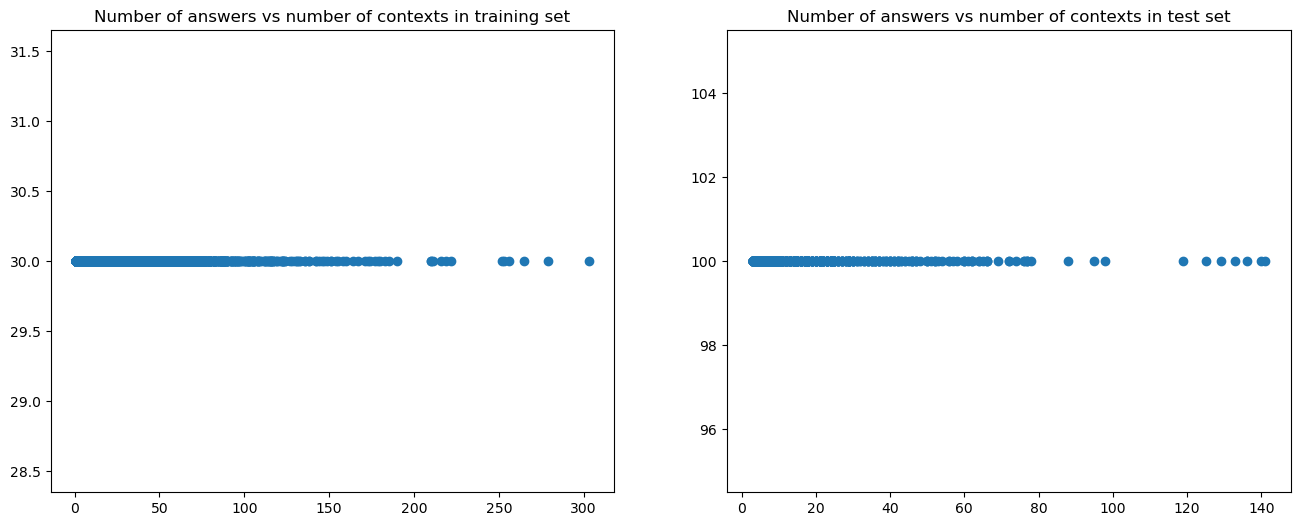

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

n_training_answers = pl_dataset_details.filter(pl.col('training'))['n_answers'].to_numpy()
n_training_contexts = pl_dataset_details.filter(pl.col('training'))['n_contexts'].to_numpy()
axs[0].scatter(n_training_answers, n_training_contexts)
axs[0].set_title('Number of answers vs number of contexts in training set')

n_test_answers = pl_dataset_details.filter(pl.col('training') == False)['n_answers'].to_numpy()
n_test_contexts = pl_dataset_details.filter(pl.col('training') == False)['n_contexts'].to_numpy()
axs[1].scatter(n_test_answers, n_test_contexts)
axs[1].set_title('Number of answers vs number of contexts in test set')

plt.show()